In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

- Map user ID to a "user vector" via an embedding matrix
- Map movie ID to a "movie vector" via an embedding matrix
- Compute the dot product between the user vector and movie vector, to obtain the a match score between the user and the movie (predicted rating).
- Train the embeddings via gradient descent using all known user-movie pairs.

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [3]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [6]:
df[df["movieId"]==50]

,userId,movieId,rating,timestamp,user,movie
4,1,50,5.0,964982931,0,4
521,5,50,4.0,847434881,4,4
589,6,50,1.0,845553381,5,4
875,7,50,4.5,1106635993,6,4
1034,8,50,5.0,839463644,7,4
...,...,...,...,...,...,...
95866,601,50,5.0,1441639169,600,4
95982,602,50,5.0,840875720,601,4
97377,606,50,4.5,1171234887,605,4
98681,608,50,4.5,1117491010,607,4


In [7]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

In [8]:
df["rating"] = df["rating"].values.astype(np.float32)

In [9]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


In [10]:
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [11]:
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [12]:
# sample of items from an axis of object.
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


In [13]:
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.

In [14]:
x

array([[ 431, 4730],
       [ 287,  474],
       [ 598, 2631],
       ...,
       [ 479, 2240],
       [   5,  712],
       [ 102, 2046]])

In [15]:
# Normalize the targets between 0 and 1. Makes it easy to train
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([0.88888889, 0.55555556, 0.55555556, ..., 0.77777778, 0.55555556,
       1.        ])

In [16]:
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [17]:
y_train

array([0.88888889, 0.55555556, 0.55555556, ..., 0.55555556, 1.        ,
       0.11111111])

In [18]:
x_train

array([[ 431, 4730],
       [ 287,  474],
       [ 598, 2631],
       ...,
       [ 589, 5054],
       [ 135,  636],
       [ 274, 3747]])

# Create the model

In [18]:
# We embed both users and movies in to 50-dimensional vectors.
# The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias.
# The match score is scaled to the [0, 1] interval via a sigmoid

In [19]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


In [20]:

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
)

In [21]:
model.get_config()

{'name': 'recommender_net',
 'trainable': True,
 'dtype': 'float32',
 'num_users': 610,
 'num_movies': 9724,
 'embedding_size': 50}

In [22]:
model.layers

In [23]:
# Function to explore model definition
def model_exploration(model,name):
    tf.keras.utils.plot_model(model, name+"_CNN.png", show_shapes=True)
    print("======== Model Layers ========")
    for layers in range(len(model.layers)):
        layer = model.layers[layers]
        print(layer.name)

# Train the model based on the data split

In [24]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6362 - val_loss: 0.6205
Epoch 2/5
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6137 - val_loss: 0.6191
Epoch 3/5
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6080 - val_loss: 0.6143
Epoch 4/5
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6073 - val_loss: 0.6124
Epoch 5/5
1418/1418 [==============================] - 2s 2ms/step - loss: 0.6068 - val_loss: 0.6122


In [25]:
! pip install pydot

In [25]:
model_exploration(model,"recommender_net_1")

======== Model Layers ========
embedding
embedding_1
embedding_2
embedding_3


# Plot training and validation loss

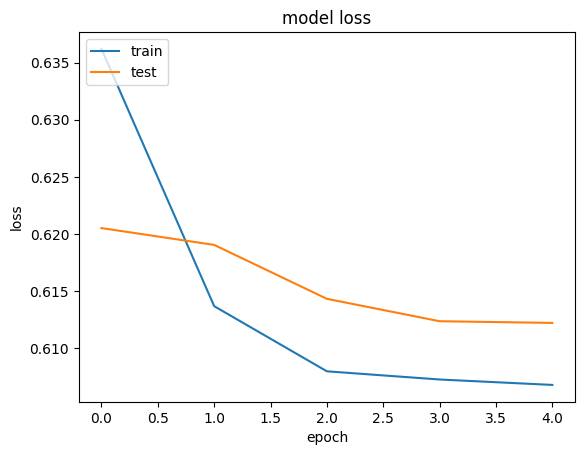

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [27]:
df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


# Show top 10 movie recommendations to a user

In [28]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

297/297 [==============================] - 0s 415us/step
Showing recommendations for user: 330
Movies with high ratings from user
--------------------------------
True Romance (1993) : Crime|Thriller
Willy Wonka & the Chocolate Factory (1971) : Children|Comedy|Fantasy|Musical
There's Something About Mary (1998) : Comedy|Romance
Kill Bill: Vol. 1 (2003) : Action|Crime|Thriller
Scott Pilgrim vs. the World (2010) : Action|Comedy|Fantasy|Musical|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Schindler's List (1993) : Drama|War
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama|Film-Noir|Romance
Dial M for Murder (1954) : Crime|Mystery|Thriller
Streetcar Named Desire, A (1951) : Drama
Man Who Would Be King, The (1975) : Adventure|Drama
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Adaptation (2002) : Comedy|Drama|Romance
City of God (Cidade de Deus) (2002) : Action|Adventure|Crime|Drama|Thriller
Watchmen (200

In [29]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")


In [61]:

# Let us get a user and see the top recommendations.
# user_id = df.userId.sample(1).iloc[0]
user_id = 1
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

In [62]:
user_id

1

In [63]:
movies_watched_by_user

,userId,movieId,rating,timestamp,user,movie
226,1,3740,4.0,964982417,0,226
149,1,2353,5.0,964983861,0,149
87,1,1278,5.0,964983414,0,87
35,1,596,5.0,964982838,0,35
134,1,2115,5.0,964982529,0,134
...,...,...,...,...,...,...
126,1,2058,5.0,964982400,0,126
77,1,1220,5.0,964981909,0,77
117,1,2000,4.0,964982211,0,117
55,1,1031,5.0,964982653,0,55


In [64]:
df.sort_values(by="userId")

,userId,movieId,rating,timestamp,user,movie
140,1,2161,5.0,964981710,0,140
98,1,1517,5.0,964981107,0,98
127,1,2078,5.0,964982838,0,127
126,1,2058,5.0,964982400,0,126
169,1,2616,4.0,964983080,0,169
...,...,...,...,...,...,...
100058,610,8810,2.5,1493845547,609,2264
100055,610,8784,3.5,1493845088,609,1227
100252,610,53161,3.0,1479545136,609,9166
100757,610,133771,4.5,1493849762,609,4802


In [65]:
(movies_not_watched)

[2,
 32770,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 32799,
 34,
 131098,
 36,
 131104,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 65577,
 48,
 49,
 65585,
 52,
 53,
 54,
 55,
 65588,
 57,
 58,
 98361,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 65596,
 68,
 69,
 65601,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 163925,
 92,
 93,
 94,
 95,
 96,
 97,
 32862,
 99,
 100,
 65631,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 32875,
 65642,
 111,
 112,
 113,
 65651,
 116,
 117,
 118,
 119,
 121,
 122,
 123,
 32892,
 125,
 126,
 128,
 129,
 32898,
 132,
 135,
 137,
 32906,
 140,
 141,
 163981,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 32914,
 152,
 153,
 154,
 155,
 156,
 32917,
 158,
 159,
 160,
 161,
 162,
 164,
 165,
 166,
 131237,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 183,
 184,
 185,
 186,
 187,
 188,
 189,

In [66]:
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

In [67]:
movies_not_watched

[[481],
 [5804],
 [482],
 [483],
 [484],
 [485],
 [5017],
 [486],
 [487],
 [1399],
 [488],
 [3678],
 [489],
 [490],
 [491],
 [2657],
 [492],
 [3604],
 [291],
 [493],
 [2163],
 [494],
 [495],
 [496],
 [497],
 [2430],
 [2068],
 [6914],
 [259],
 [292],
 [8955],
 [460],
 [3938],
 [461],
 [3939],
 [1859],
 [462],
 [6704],
 [498],
 [5992],
 [499],
 [971],
 [293],
 [500],
 [4192],
 [1400],
 [5596],
 [4529],
 [294],
 [3711],
 [501],
 [3679],
 [3811],
 [2651],
 [295],
 [3635],
 [502],
 [503],
 [504],
 [5832],
 [1401],
 [505],
 [506],
 [1290],
 [4035],
 [2663],
 [6684],
 [4663],
 [5550],
 [4698],
 [2420],
 [5018],
 [507],
 [9348],
 [2421],
 [508],
 [6915],
 [4036],
 [2503],
 [5687],
 [4037],
 [509],
 [510],
 [511],
 [512],
 [4432],
 [513],
 [514],
 [2431],
 [515],
 [8152],
 [5289],
 [9533],
 [5551],
 [516],
 [6792],
 [517],
 [8579],
 [518],
 [519],
 [296],
 [1402],
 [9349],
 [2799],
 [4765],
 [1093],
 [520],
 [521],
 [5643],
 [4038],
 [9411],
 [1403],
 [7421],
 [2504],
 [2543],
 [6019],
 [4309],

In [75]:
df[df["movieId"]==2]

,userId,movieId,rating,timestamp,user,movie
10361,68,2,2.5,1158532776,67,481
33045,226,2,3.0,1095662788,225,481
43958,294,2,3.0,966634189,293,481
82614,525,2,3.5,1476480324,524,481
68656,448,2,3.0,1019125424,447,481
...,...,...,...,...,...,...
78471,489,2,2.5,1333101570,488,481
81532,517,2,3.0,1487954340,516,481
20337,135,2,3.0,1009692764,134,481
68577,447,2,5.0,836961067,446,481


In [69]:
user_encoder = user2user_encoded.get(user_id)
user_encoder

0

In [70]:
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [71]:
user_movie_array

array([[   0,  481],
       [   0, 5804],
       [   0,  482],
       ...,
       [   0, 3870],
       [   0, 2989],
       [   0, 7869]])

In [ ]:



ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)